In [1]:
import urllib.request
import os
import tarfile

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'

if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print('Downloaded:', result)
else:
    print('Data file already exists.')
    
if not os.path.exists('data/cifar-10-batches-py'):
    tfile = tarfile.open(filepath, 'r:gz')
    result = tfile.extractall('data/')
    print('Extracted to ./data/cifar-10-batches-py/')
else:
    print('Directory already exists.')

Data file already exists.
Directory already exists.


In [2]:
import numpy as np
import pickle as p

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = p.load(f, encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        images = images.reshape(10000, 3, 32, 32)
        
        images = images.transpose(0, 2, 3, 1)
        
        labels = np.array(labels)
        
        return images, labels
    
def load_CIFAR_data(data_dir):
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir, 'data_batch_%d' % (i+1))
        print('loading', f)
        
        image_batch, label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch, label_batch
    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir, 'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    return Xtrain, Ytrain, Xtest, Ytest

data_dir = 'data/cifar-10-batches-py/'
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


In [3]:
print('training data shape:', Xtrain.shape)
print('training labels shape:', Ytrain.shape)
print('test data shape:', Xtest.shape)
print('test labels shape:', Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


2 bird


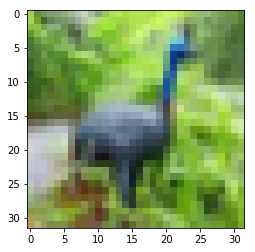

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

classlst = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.imshow(Xtrain[6])
print(Ytrain[6], classlst[Ytrain[6]])

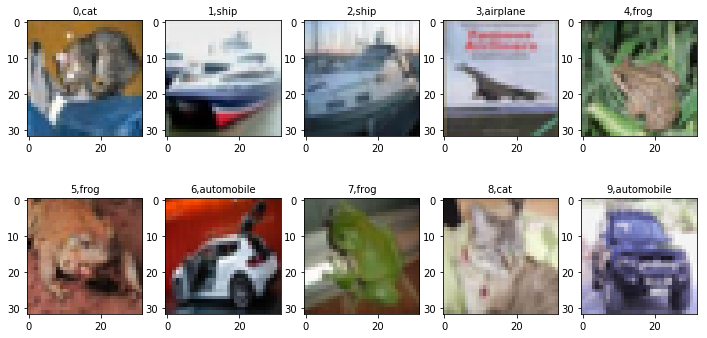

In [5]:
import matplotlib.pyplot as plt

label_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',
              4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',
              9:'truck'}

def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    if num > 10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(images[idx], cmap='binary')
        
        title = str(i) + ',' + label_dict[labels[idx]]
        if len(prediction) > 0:
            title += '=>' + label_dict[prediction[idx]]
        ax.set_title(title, fontsize=10)
        idx += 1
    plt.show()
    
plot_images_labels_prediction(Xtest, Ytest, [], 0, 10)

In [6]:
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

In [7]:
Xtrain_normalize = Xtrain.astype('float32') / 255.0
Xtest_normalize = Xtest.astype('float32') / 255.0

In [8]:
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [9]:
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)

Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytrain_reshape)

In [11]:
Ytrain_onehot.shape

(50000, 10)

In [12]:
Ytrain[:5]
Ytest_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
import tensorflow as tf
tf.reset_default_graph()

E:\python\python_install\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='b')

def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [15]:
# 输入层
# 32x32图像，通道数为3
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None,32,32,3], name='x')

# 第1个卷积层
# 输入通道：3，输出通道：32，卷积后图像尺寸32x32
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32])
    b1 = bias([32])
    conv_1 = conv2d(x, W1) + b1
    conv_1 = tf.nn.relu(conv_1)
    

# 第1个池化层
# 将32x32图像缩小为16x16
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)


# 第2个卷积层
# 输入通道：32，输出通道：64，卷积后图像尺寸16x16
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])
    b2 = bias([64])
    conv_2 = conv2d(pool_1, W2) + b2
    conv_2 = tf.nn.relu(conv_2)
    

# 第2个池化层
# 将16x16的图像缩小为8x8
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)
    

# 全连接层
# 将第2个池化层的64个图像转化为一维的向量，长度是8x8x64=4096
with tf.name_scope('fc'):
    W3 = weight([4096,128])
    b3 = bias([128])
    flat = tf.reshape(pool_2, [-1,4096])
    h = tf.nn.relu(tf.matmul(flat, W3)+b3)
    h_dropout = tf.nn.dropout(h, keep_prob=0.8)
    
# 输出层
with tf.name_scope('output_layer'):
    W4 = weight([128,10])
    b4 = bias([10])
    forward = tf.matmul(h_dropout, W4)+b4
    pred = tf.nn.softmax(forward)

In [16]:
with tf.name_scope('optimizer'):
    y = tf.placeholder('float', shape=[None,10])
    
    loss_function = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=forward,
            labels=y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)\
    .minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [17]:
with tf.name_scope('evaluation'):
    correct_predition = tf.equal(tf.argmax(pred,1),
                                tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_predition, tf.float32))

In [18]:
import os
from time import time

train_epochs = 25
batch_size = 50
total_batch = int(len(Xtrain)/batch_size)
epoch_list=[];accuracy_list=[];loss_list=[];

epoch = tf.Variable(0, name='epoch', trainable=False)

startTime = time()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
ckpt_dir = 'CIFAR10_log/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
saver = tf.train.Saver(max_to_keep=2)

ckpt = tf.train.get_checkpoint_state(ckpt_dir)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    print('Training from scratch.')

start = sess.run(epoch)
print('Training starts from {} epoch.'.format(start+1))

Training from scratch.
Training starts from 1 epoch.


In [22]:
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number*batch_size:(number+1)*batch_size],\
            Ytrain_onehot[number*batch_size:(number+1)*batch_size]

for ep in range(start, train_epochs):
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i, batch_size)
        sess.run(optimizer, feed_dict={x:batch_x,y:batch_y})
        if i % 100 == 0:
            print('Step {}'.format(i), 'finished')
    loss, acc = sess.run([loss_function,accuracy], feed_dict={x:batch_x,y:batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss)
    accuracy_list.append(acc)
    
    print('Train epoch %02d:' % (sess.run(epoch)+1),\
          'Loss={:.6f}'.format(loss),'Accuary=%.6f' % acc)
    saver.save(sess, ckpt_dir+'CIFAR10_cnn_model.ckpt', global_step=ep+1)
    sess.run(epoch.assign(ep+1))
    
duration = time() - startTime
print('Train finished takes:',duration)

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch 01: Loss=2.022510 Accuary=0.240000
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch 02: Loss=1.996752 Accuary=0.280000
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch 03: Loss=1.815754 Accuary=0.380000
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch 04: Loss=1.851746 Accuary=0.380000
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 fin

In [27]:
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict={x:test_image_batch,y:test_label_batch})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum / test_total_batch)
print('Test accuracy:{:.6f}'.format(test_acc))

Test accuracy:0.100600


In [24]:
test_pred = sess.run(pred, feed_dict={x:Xtest_normalize[:10]})
prediction_result = sess.run(tf.argmax(test_pred,1))

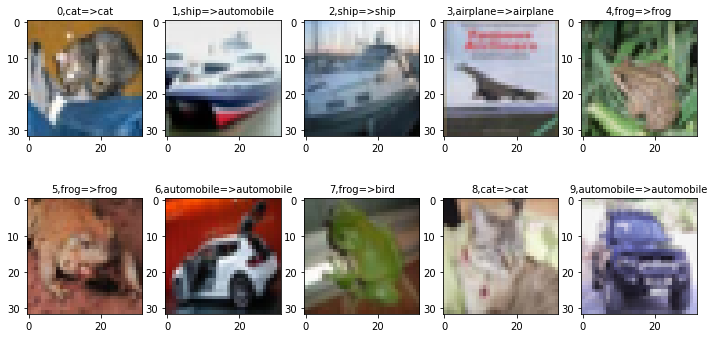

In [25]:
plot_images_labels_prediction(Xtest, Ytest, prediction_result, 0, 10)